In [1]:
import numpy as np
from utils_adaptive import run_adaptive
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams.update({'font.size': 14})
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('legend', fontsize=12)
matplotlib.rcParams['savefig.dpi'] = 1200

%load_ext autoreload
%autoreload 2
import time
import scipy.stats as scs
import math

from utils_carryover import theta1, theta2
from utils_adaptive import *
from utils_empirical import *

In [2]:
out_dir = "../result/flu-adaptive/"
out_path = out_dir 
save_path = out_dir + "flu_adaptive.pkl"

In [3]:
N = 50; 
fs_pct = 0.2; t0 = 3; 
num_mc = 10000

Y = import_MS_FLU_pos_data()
tau_ratio = -0.1

tau = np.mean(Y)*tau_ratio

summary = dict()
prec_thres = N/tau**2 * 15e-3

var_thres = 1/prec_thres * 1e6

In [4]:
start_time = time.time()
# for T_max in [7]:
for T_max in [7, 14, 21, 28]:
    
    np.random.seed(123)
    print(T_max)
    idx_N_list, idx_T_list, shuffle_list = sample_subblocks(Y, N, T_max, num_mc=num_mc)
    all_Ys = get_all_Ys(Y, idx_N_list, idx_T_list, shuffle_list)
    out = run_adaptive(tau, fs_pct=fs_pct, num_mc=num_mc,
                   t0=t0, adaptive=True, prec_thres=prec_thres, print_out=False, print_epochs=500, all_Ys=all_Ys)
    out_df = pd.DataFrame(out)
    print(np.mean(out_df["tau_adaptive"]**2), np.mean(out_df["tau_bm"]**2), np.mean(out_df["tau_oracle"]**2))

    summary[T_max] = out_df
    with open(save_path, 'wb') as handle:
        pickle.dump(summary, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(time.time() - start_time)

7


/Users/ruoxuanxiong/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx


500/10000 done
1000/10000 done
1500/10000 done
2000/10000 done
2500/10000 done
3000/10000 done
3500/10000 done
4000/10000 done
4500/10000 done
5000/10000 done
5500/10000 done
6000/10000 done
6500/10000 done
7000/10000 done
7500/10000 done
8000/10000 done
8500/10000 done
9000/10000 done
9500/10000 done
10000/10000 done
4.8285508847007604e-08 4.924043803095802e-08 4.093089613381751e-08
186.56322693824768
14
500/10000 done
1000/10000 done
1500/10000 done
2000/10000 done
2500/10000 done
3000/10000 done
3500/10000 done
4000/10000 done
4500/10000 done
5000/10000 done
5500/10000 done
6000/10000 done
6500/10000 done
7000/10000 done
7500/10000 done
8000/10000 done
8500/10000 done
9000/10000 done
9500/10000 done
10000/10000 done
5.047331398159384e-08 6.241066194817434e-08 3.3253969992857605e-08
20353.387006044388
21
500/10000 done
1000/10000 done
1500/10000 done
2000/10000 done
2500/10000 done
3000/10000 done
3500/10000 done
4000/10000 done
4500/10000 done
5000/10000 done
5500/10000 done
6000/10

In [5]:
T_col = '${T}_\mathrm{max}$'; val_col = '$(\hat{\\tau}_0 - \\tau_0)^2$'; method_col = '$\mathrm{design}$'
method_dict = {'bm': '$\mathrm{benchmark}$', 'oracle': '$\mathrm{oracle}$', 'adaptive': '$\mathrm{adaptive}$', 'var': '$\mathrm{variance \,\,threshold\,\,} 1/c$'}
out = dict()
out[val_col] = list(); out[method_col] = list(); out[T_col] = list()


T_list = [7,14,21,28]
for T_max in T_list:
    this_out = summary[T_max] * 1e3
    num_mc = this_out.shape[0] 
    out[T_col] = out[T_col] + [T_max] * (num_mc * 4)
    out[method_col] = out[method_col] + [method_dict['bm']] * num_mc + [method_dict['oracle']] * num_mc + [method_dict['adaptive']] * num_mc + [method_dict['var']] * num_mc
    out[val_col] = out[val_col] + list(this_out['tau_bm'] ** 2) + list(this_out['tau_oracle'] ** 2) + list(this_out['tau_adaptive'] ** 2) + [var_thres] * num_mc
    
out_df = pd.DataFrame(out)

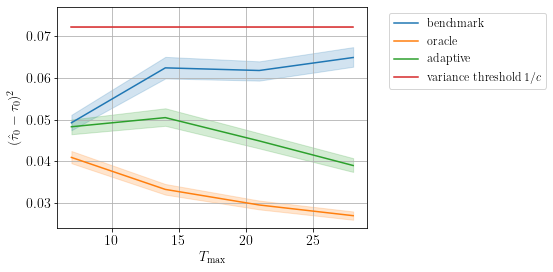

In [6]:
fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(8,4))
sns.lineplot(ax=axes, data=out_df, x=T_col, y=val_col, hue=method_col,estimator=np.mean, err_style="band")

axes.tick_params('x', labelrotation=360)
axes.set_xlabel(T_col)
axes.set_ylabel(val_col)
axes.set_ylim([0.024, 0.077])
axes.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes.grid()

plt.tight_layout()

plt.savefig(out_dir+"flu_adaptive_comparison.pdf")

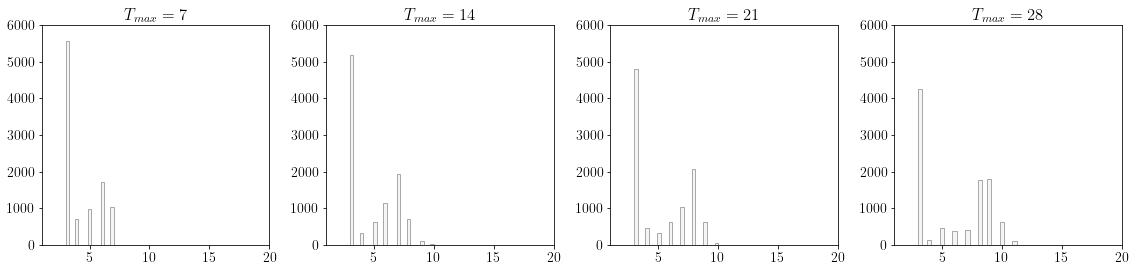

In [7]:
num_Ts = len(T_list)
fig, axes = plt.subplots(nrows=1,ncols=num_Ts,figsize=(4*num_Ts,4))

for i in range(num_Ts):
    T = T_list[i]
    if i == 0:
        axes[i].hist(summary[T]['T_ast'], bins= 15, color="whitesmoke", edgecolor="darkgrey", density=False)
    elif i == 1 or i == 2:
        axes[i].hist(summary[T]['T_ast'], bins= 25, color="whitesmoke", edgecolor="darkgrey", density=False)
    else:
        axes[i].hist(summary[T]['T_ast'], bins= T_list[-1], color="whitesmoke", edgecolor="darkgrey", density=False)
    axes[i].set_title("$T_{max}="+str(T)+"$")
    axes[i].set_xlim([1, 20])
    axes[i].set_ylim([0, 6001])
plt.tight_layout()
plt.savefig(out_dir+"flu_termination_time.pdf")